# Ï†ÑÏ≤òÎ¶¨ Î∞è Î≥ÄÏàòÏÑ†ÌÉù 

In [3]:
# ======================================
# 1Ô∏è‚É£ Ï†ÑÏ≤òÎ¶¨ Î∞è Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
# ======================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from itertools import combinations

# -------------------------
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# Í≤∞Ï∏°Ïπò Ïª¨Îüº Ï†úÍ±∞
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area Í¥ÄÎ†® Î≥ÄÏàò Ï†úÍ±∞
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# Ïò§ÌÉÄ ÏàòÏ†ï
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# Î≤îÏ£ºÌòï Î≥ÄÏàò Îß§Ìïë Î∞è Ïõê-Ìï´ Ïù∏ÏΩîÎî©
# -------------------------
# dance_years Îß§Ìïë
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# Ïõê-Ìï´ Ïù∏ÏΩîÎî©
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, dtype=float)

# -------------------------
# Î∂ÑÏÑù Ï†úÏô∏ Î≥ÄÏàò Ï†úÍ±∞
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# sat Î≥ÄÏàò ÏÉùÏÑ± Î∞è Ïù¥ÏßÑ Î∂ÑÎ•ò
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# ÏÑ§Î™ÖÏö© Ï∂úÎ†•
# -------------------------
print("‚úÖ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº Ïàò:", df.shape[1])
print("sat Ï§ëÏúÑÏàò:", sat_median)
print(df[['sat', 'sat_group']].head())


‚úÖ ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº Ïàò: 183
sat Ï§ëÏúÑÏàò: 4.0
    sat  sat_group
0  4.00          1
1  4.50          1
2  3.00          0
3  3.00          0
4  4.75          1


In [4]:
# ======================================
# 2Ô∏è‚É£ Î≥ÄÏàò ÏÑ†ÌÉù (ElasticNet + RFECV)
# ======================================
X = df.drop(columns=['id','univ_proud','univ_belong','major_proud','major_belong','sat_group','sat'], errors='ignore')
y = df['sat_group']

n_repeat = 5  # Î∞òÎ≥µ ÌöüÏàò

# ÏÑ†ÌÉù Î≥ÄÏàò Ï†ÄÏû•
enet_selected_list = []
rfecv_lr_selected_list = []
rfecv_dt_selected_list = []
rfecv_rf_selected_list = []
rfecv_xgb_selected_list = []

for i in range(n_repeat):
    # -------------------------
    # ElasticNet (LogisticRegressionCV + l1+l2 Í∑úÏ†ú ÌòºÌï©)
    # -------------------------
    enet_clf = LogisticRegressionCV(
        penalty='elasticnet',
        solver='saga',            # elasticnet Í∞ÄÎä• solver
        l1_ratios=[0.1,0.5,0.7,0.9,1],  # L1/L2 ÌòºÌï© ÎπÑÏú®
        cv=5,                     # ÎÇ¥Î∂Ä 5-fold CV
        max_iter=2000,
        scoring='f1',
        random_state=i
    )
    enet_clf.fit(X, y)
    coefs = enet_clf.coef_[0]
    enet_selected_list.append(set(X.columns[coefs != 0]))

    # -------------------------
    # StratifiedKFold (RFECVÏö©)
    # -------------------------
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

    # -------------------------
    # RFECV(LR)
    # -------------------------
    lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000, solver='liblinear', random_state=i))
    ])
    rfecv_lr = RFECV(
        estimator=lr_pipe,
        step=1,
        cv=cv,
        scoring='f1',
        min_features_to_select=5,
        n_jobs=-1,
        importance_getter='named_steps.lr.coef_'
    )
    rfecv_lr.fit(X, y)
    rfecv_lr_selected_list.append(set(X.columns[rfecv_lr.support_]))

    # -------------------------
    # RFECV(Decision Tree)
    # -------------------------
    dt = DecisionTreeClassifier(random_state=i)
    rfecv_dt = RFECV(estimator=dt, step=1, cv=cv,
                     scoring='f1', min_features_to_select=5, n_jobs=-1)
    rfecv_dt.fit(X, y)
    rfecv_dt_selected_list.append(set(X.columns[rfecv_dt.support_]))

    # -------------------------
    # RFECV(Random Forest)
    # -------------------------
    rf = RandomForestClassifier(random_state=i)
    rfecv_rf = RFECV(estimator=rf, step=1, cv=cv,
                     scoring='f1', min_features_to_select=5, n_jobs=-1)
    rfecv_rf.fit(X, y)
    rfecv_rf_selected_list.append(set(X.columns[rfecv_rf.support_]))

    # -------------------------
    # RFECV(XGBoost)
    # -------------------------
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i)
    rfecv_xgb = RFECV(estimator=xgb, step=1, cv=cv,
                      scoring='f1', min_features_to_select=5, n_jobs=-1)
    rfecv_xgb.fit(X, y)
    rfecv_xgb_selected_list.append(set(X.columns[rfecv_xgb.support_]))

# -------------------------
# Î∞òÎ≥µ ÏÑ†ÌÉù Î≥ÄÏàò Í≥µÌÜµ (Jaccard ÏïàÏ†ïÏÑ± ÌèâÍ∞Ä)
# -------------------------
def jaccard_index(list_of_sets):
    pairs = list(combinations(range(len(list_of_sets)), 2))
    scores = []
    for i,j in pairs:
        a,b = list_of_sets[i], list_of_sets[j]
        scores.append(len(a & b) / len(a | b) if len(a | b) > 0 else 0)
    return np.mean(scores)

enet_jaccard = jaccard_index(enet_selected_list)
rfecv_lr_jaccard = jaccard_index(rfecv_lr_selected_list)
rfecv_dt_jaccard = jaccard_index(rfecv_dt_selected_list)
rfecv_rf_jaccard = jaccard_index(rfecv_rf_selected_list)
rfecv_xgb_jaccard = jaccard_index(rfecv_xgb_selected_list)

print("üîπ ÌèâÍ∑† Jaccard ÏßÄÏàò (ÏïàÏ†ïÏÑ± ÌèâÍ∞Ä)")
print(f"ElasticNet: {enet_jaccard:.3f}")
print(f"RFECV(LR): {rfecv_lr_jaccard:.3f}")
print(f"RFECV(DT): {rfecv_dt_jaccard:.3f}")
print(f"RFECV(RF): {rfecv_rf_jaccard:.3f}")
print(f"RFECV(XGB): {rfecv_xgb_jaccard:.3f}")

# -------------------------
# Î∞òÎ≥µ Í≥µÌÜµ Î≥ÄÏàò ÎèÑÏ∂ú
# -------------------------
enet_common = set.intersection(*enet_selected_list)
rfecv_lr_common = set.intersection(*rfecv_lr_selected_list)
rfecv_dt_common = set.intersection(*rfecv_dt_selected_list)
rfecv_rf_common = set.intersection(*rfecv_rf_selected_list)
rfecv_xgb_common = set.intersection(*rfecv_xgb_selected_list)


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

üîπ ÌèâÍ∑† Jaccard ÏßÄÏàò (ÏïàÏ†ïÏÑ± ÌèâÍ∞Ä)
ElasticNet: 1.000
RFECV(LR): 0.753
RFECV(DT): 0.293
RFECV(RF): 0.746
RFECV(XGB): 0.704


In [4]:
# ======================================
# 3Ô∏è‚É£ Cross-validated F1 ÌèâÍ∞Ä
# ======================================
def cv_f1(X_subset, y, model, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    return cross_val_score(model, X_subset, y, cv=cv, scoring='f1').mean()

models = {
    "ElasticNet": LogisticRegressionCV(penalty='elasticnet', solver='saga', 
                                       l1_ratios=[0.5], cv=5, max_iter=2000),
    "RFECV(LR)": LogisticRegression(max_iter=1000, solver='liblinear'),
    "RFECV(DT)": DecisionTreeClassifier(),
    "RFECV(RF)": RandomForestClassifier(),
    "RFECV(XGB)": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

subset_dict = {
    "ElasticNet": list(enet_common),
    "RFECV(LR)": list(rfecv_lr_common),
    "RFECV(DT)": list(rfecv_dt_common),
    "RFECV(RF)": list(rfecv_rf_common),
    "RFECV(XGB)": list(rfecv_xgb_common)
}

for name, model in models.items():
    X_sub = X[subset_dict[name]]
    score = cv_f1(X_sub, y, model)
    print(f"{name} ÏµúÏ¢Ö ÌõÑÎ≥¥ Î≥ÄÏàò CV F1: {score:.3f}")

# ======================================
# 4Ô∏è‚É£ Hold-out/Test ÏÑ±Îä• ÌôïÏù∏
# ======================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("üîπ Hold-out(Test) F1 Score")
for name, model in models.items():
    X_train_sub = X_train[subset_dict[name]]
    X_test_sub = X_test[subset_dict[name]]
    
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)
    score = f1_score(y_test, y_pred)
    
    print(f"{name}: {score:.3f}")

ElasticNet ÏµúÏ¢Ö ÌõÑÎ≥¥ Î≥ÄÏàò CV F1: 0.868
RFECV(LR) ÏµúÏ¢Ö ÌõÑÎ≥¥ Î≥ÄÏàò CV F1: 0.867
RFECV(DT) ÏµúÏ¢Ö ÌõÑÎ≥¥ Î≥ÄÏàò CV F1: 0.829
RFECV(RF) ÏµúÏ¢Ö ÌõÑÎ≥¥ Î≥ÄÏàò CV F1: 0.868


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

RFECV(XGB) ÏµúÏ¢Ö ÌõÑÎ≥¥ Î≥ÄÏàò CV F1: 0.864
üîπ Hold-out(Test) F1 Score
ElasticNet: 0.857
RFECV(LR): 0.879
RFECV(DT): 0.790
RFECV(RF): 0.886
RFECV(XGB): 0.867


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


üîπ ElasticNet ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ ÌôïÏù∏ (ÎßàÏßÄÎßâ Î∞òÎ≥µ Í∏∞Ï§Ä)
ÏµúÏ†Å l1_ratio (Œ±, L1/L2 ÌòºÌï©ÎπÑ): 0.7
ÏµúÏ†Å C (Í∑úÏ†ú Í∞ïÎèÑ Ïó≠Ïàò): 0.046415888336127774
ÏµúÏ†Å Œª (alpha, Í∑úÏ†ú Í∞ïÎèÑ): 21.544346900318843
ÌõÑÎ≥¥ C Î∞∞Ïó¥: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
ÏµúÏ†Å Œ± Ïù∏Îç±Ïä§: 2
ÏµúÏ†Å C Ïù∏Îç±Ïä§: 3


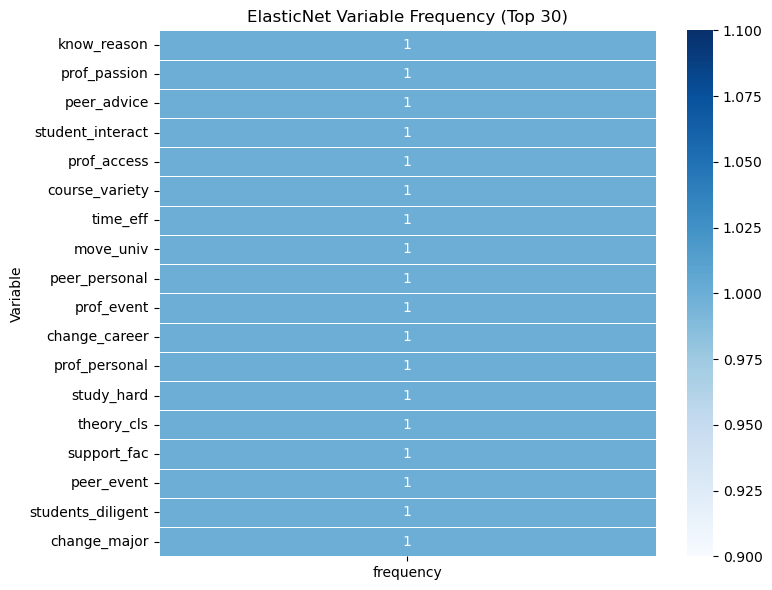

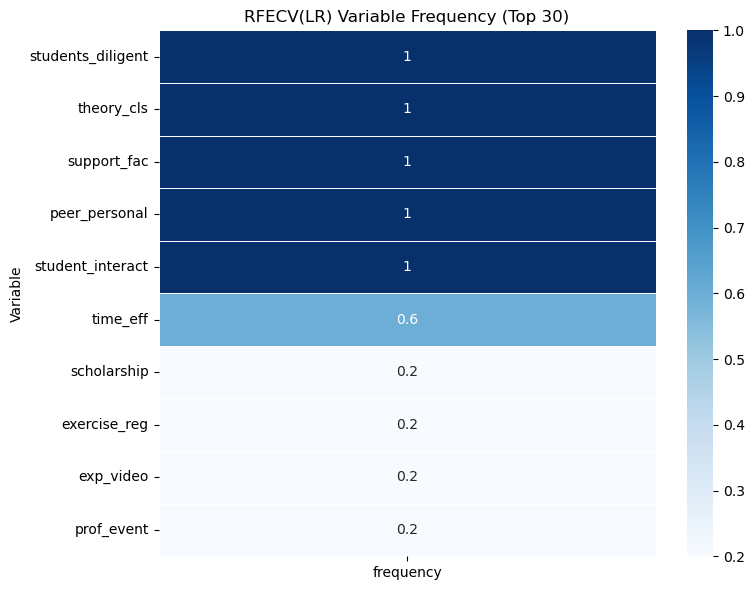

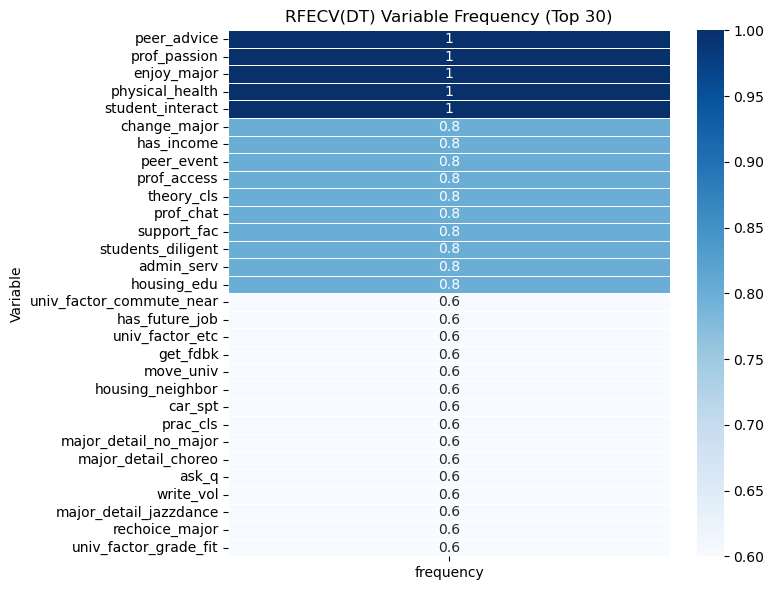

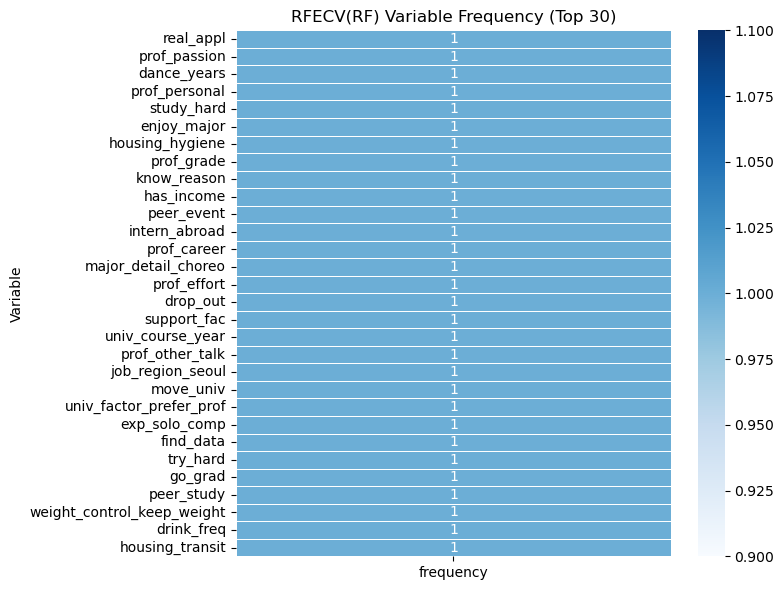

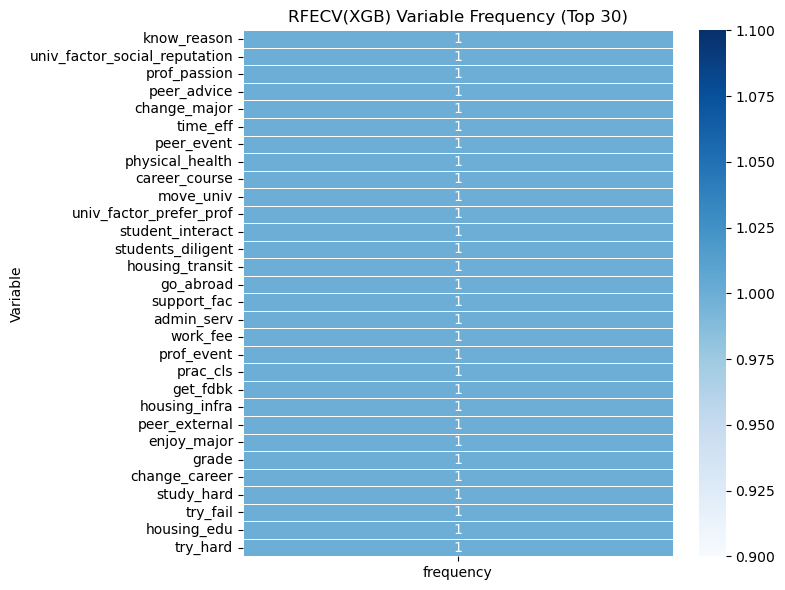

In [5]:
# ======================================
# 5Ô∏è‚É£ ElasticNet ÏµúÏ†Å Œ± / C ÌôïÏù∏
# ======================================
# ‚ö†Ô∏è Ï£ºÏùò: enet_clfÎäî Î∞òÎ≥µ ÎßàÏßÄÎßâ fold Í∏∞Ï§Ä
print("üîπ ElasticNet ÏµúÏ†Å ÌååÎùºÎØ∏ÌÑ∞ ÌôïÏù∏ (ÎßàÏßÄÎßâ Î∞òÎ≥µ Í∏∞Ï§Ä)")
print("ÏµúÏ†Å l1_ratio (Œ±, L1/L2 ÌòºÌï©ÎπÑ):", enet_clf.l1_ratio_[0])
print("ÏµúÏ†Å C (Í∑úÏ†ú Í∞ïÎèÑ Ïó≠Ïàò):", enet_clf.C_[0])
print("ÏµúÏ†Å Œª (alpha, Í∑úÏ†ú Í∞ïÎèÑ):", 1/enet_clf.C_[0])  # Œª = 1/C

# ÌõÑÎ≥¥ C Î∞∞Ïó¥ ÌôïÏù∏
print("ÌõÑÎ≥¥ C Î∞∞Ïó¥:", enet_clf.Cs_)

# ÏµúÏ†Å Œ± / C Ïù∏Îç±Ïä§ ÌôïÏù∏
import numpy as np
optimal_C_index = np.where(enet_clf.Cs_ == enet_clf.C_[0])[0][0]
optimal_alpha_index = np.where(np.array(enet_clf.l1_ratios) == enet_clf.l1_ratio_[0])[0][0]
print("ÏµúÏ†Å Œ± Ïù∏Îç±Ïä§:", optimal_alpha_index)
print("ÏµúÏ†Å C Ïù∏Îç±Ïä§:", optimal_C_index)

# ======================================
# 6Ô∏è‚É£ Î∞òÎ≥µ ÏÑ†ÌÉù Î≥ÄÏàò ÎπàÎèÑ Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî
# ======================================
import collections
import matplotlib.pyplot as plt
import seaborn as sns

def variable_frequency(selected_list, n_repeat=5):
    """
    Î∞òÎ≥µ ÏÑ†ÌÉùÎêú Î≥ÄÏàò Î¶¨Ïä§Ìä∏ÏóêÏÑú ÎπàÎèÑ Í≥ÑÏÇ∞
    selected_list: list of set
    n_repeat: Î∞òÎ≥µ ÌöüÏàò
    """
    counter = collections.Counter()
    for s in selected_list:
        counter.update(s)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    freq_df['frequency'] = freq_df['count'] / n_repeat  # ÏÑ†ÌÉù ÎπÑÏú®
    return freq_df.sort_values(by='frequency', ascending=False)

# ÎπàÎèÑ Í≥ÑÏÇ∞
enet_freq = variable_frequency(enet_selected_list, n_repeat)
rfecv_lr_freq = variable_frequency(rfecv_lr_selected_list, n_repeat)
rfecv_dt_freq = variable_frequency(rfecv_dt_selected_list, n_repeat)
rfecv_rf_freq = variable_frequency(rfecv_rf_selected_list, n_repeat)
rfecv_xgb_freq = variable_frequency(rfecv_xgb_selected_list, n_repeat)

# ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
def plot_freq_heatmap(freq_df, title, top_n=30):
    top_vars = freq_df.head(top_n)
    plt.figure(figsize=(8,6))
    sns.heatmap(top_vars[['frequency']], annot=True, cmap='Blues', cbar=True, linewidths=0.5)
    plt.title(title)
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()

# ÏÉÅÏúÑ 30Í∞ú Î≥ÄÏàò ÌûàÌä∏Îßµ
plot_freq_heatmap(enet_freq, 'ElasticNet Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_lr_freq, 'RFECV(LR) Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_dt_freq, 'RFECV(DT) Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_rf_freq, 'RFECV(RF) Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_xgb_freq, 'RFECV(XGB) Variable Frequency (Top 30)')


In [14]:
# XÏùò Ï†ÑÏ≤¥ Ïª¨Îüº ÌôïÏù∏
print("X Ïª¨Îüº Ïàò:", len(X.columns))
print(X.columns.tolist())

X Ïª¨Îüº Ïàò: 176
['univ_rank', 'major_rank', 'know_reason', 'prof_exp', 'study_hard', 'time_eff', 'edu_doubt', 'learn_fun', 'study_mate', 'try_hard', 'write_vol', 'find_data', 'self_study', 'try_fail', 'get_fdbk', 'real_appl', 'ask_q', 'fit_major', 'enjoy_major', 'cont_major', 'rechoice_major', 'move_univ', 'change_major', 'change_career', 'take_leave', 'drop_out', 'go_abroad', 'go_grad', 'work_fee', 'has_future_job', 'has_income', 'has_major_income', 'smoke_exp', 'drink_freq', 'exercise_reg', 'burnout', 'mental_health', 'physical_health', 'housing_infra', 'housing_transit', 'housing_safety', 'housing_hygiene', 'housing_green', 'housing_culture', 'housing_edu', 'housing_neighbor', 'move_for_univ', 'stay_after', 'lecture_fac', 'support_fac', 'scholarship', 'tuition', 'transport', 'prac_cls', 'theory_cls', 'prof_effort', 'lecture_qual', 'admin_serv', 'car_spt', 'intern_abroad', 'career_course', 'career_mentoring', 'job_test', 'job_prep', 'field_practice', 'abroad_practice', 'job_info', 

# ÏµúÏ†ÅÎ≥ÄÏàòÌõÑÎ≥¥[RFECV(LR), ENET] Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌôïÏù∏ 

=== ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌñâÎ†¨ ===
                   students_diligent  student_interact  peer_personal  \
students_diligent              1.000             0.449          0.364   
student_interact               0.449             1.000          0.370   
peer_personal                  0.364             0.370          1.000   
theory_cls                     0.404             0.344          0.283   
support_fac                    0.191             0.080          0.122   

                   theory_cls  support_fac  
students_diligent       0.404        0.191  
student_interact        0.344        0.080  
peer_personal           0.283        0.122  
theory_cls              1.000        0.381  
support_fac             0.381        1.000  

=== ÏÉÅÍ¥ÄÍ≥ÑÏàò Ïú†ÏùòÌôïÎ•†(p-value) ===
                   students_diligent  student_interact  peer_personal  \
students_diligent                0.0             0.000          0.000   
student_interact                 0.0             0.000          0.000   


C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53469 (\N{HANGUL SYLLABLE TAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarni

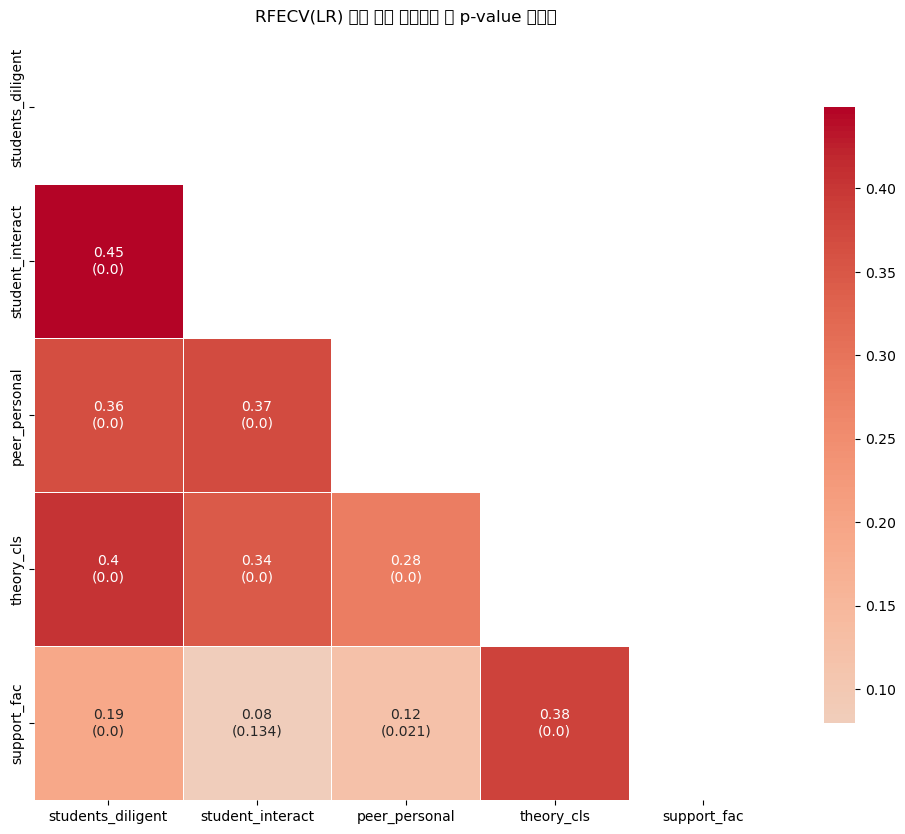

In [23]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# -------------------------
# Í∞ÄÏû• ÏµúÍ∑º RFECV(LR) ÏÑ†ÌÉù Î≥ÄÏàò
# -------------------------
selected_vars = list(rfecv_lr_selected_list[-1])
X_sel = X[selected_vars]

# -------------------------
# ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∞è p-value Í≥ÑÏÇ∞
# -------------------------
corr_matrix = pd.DataFrame(index=selected_vars, columns=selected_vars, dtype=float)
pval_matrix = pd.DataFrame(index=selected_vars, columns=selected_vars, dtype=float)

for i in selected_vars:
    for j in selected_vars:
        corr, pval = pearsonr(X_sel[i], X_sel[j])
        corr_matrix.loc[i, j] = corr
        pval_matrix.loc[i, j] = pval

print("=== ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌñâÎ†¨ ===")
print(corr_matrix.round(3))

print("\n=== ÏÉÅÍ¥ÄÍ≥ÑÏàò Ïú†ÏùòÌôïÎ•†(p-value) ===")
print(pval_matrix.round(3))

# -------------------------
# VIF Í≥ÑÏÇ∞
# -------------------------
X_const = sm.add_constant(X_sel)
vif_data = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})
print("\n=== VIF Í≤∞Í≥º ===")
print(vif_data.round(3))

# -------------------------
# ÌûàÌä∏Îßµ (ÏÉÅÍ¥ÄÍ≥ÑÏàò ¬± p-value)
# -------------------------
plt.figure(figsize=(12,10))
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # ÏÉÅÏÇºÍ∞ÅÎßå ÌëúÏãú

# ÏÖÄÏóê ÌëúÏãúÌï† Î¨∏ÏûêÏó¥ ÏÉùÏÑ±: "corr\n(p-value)"
annot = corr_matrix.round(2).astype(str) + "\n(" + pval_matrix.round(3).astype(str) + ")"

sns.heatmap(corr_matrix.astype(float), annot=annot, fmt="", cmap='coolwarm', mask=mask,
            cbar_kws={"shrink": 0.8}, linewidths=0.5, center=0)
plt.title("RFECV(LR) ÏÑ†ÌÉù Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∞è p-value ÌûàÌä∏Îßµ")
plt.show()



C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53469 (\N{HANGUL SYLLABLE TAEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarni

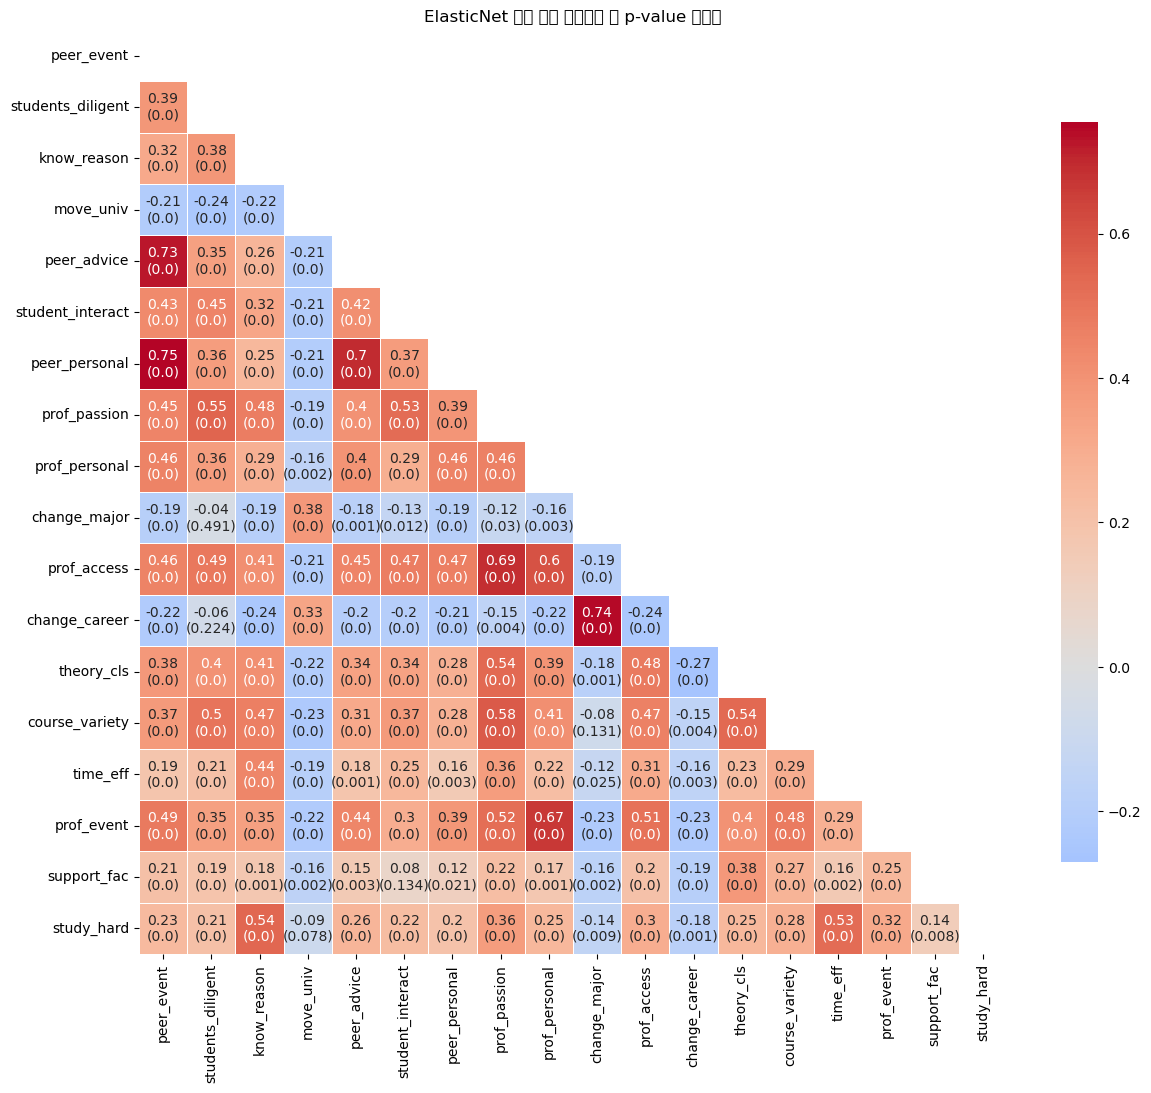


=== VIF Í≤∞Í≥º ===
              feature     VIF
0               const  66.348
1          peer_event   3.186
2   students_diligent   1.753
3         know_reason   1.883
4           move_univ   1.302
5         peer_advice   2.563
6    student_interact   1.639
7       peer_personal   2.831
8        prof_passion   2.840
9       prof_personal   2.333
10       change_major   2.430
11        prof_access   2.607
12      change_career   2.440
13         theory_cls   1.860
14     course_variety   1.975
15           time_eff   1.532
16         prof_event   2.336
17        support_fac   1.237
18         study_hard   1.727


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -------------------------
# Í∞ÄÏû• ÏµúÍ∑º ElasticNet ÏÑ†ÌÉù Î≥ÄÏàò
# -------------------------
selected_vars = list(enet_selected_list[-1])
X_sel = X[selected_vars]

# -------------------------
# ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∞è p-value Í≥ÑÏÇ∞
# -------------------------
corr_matrix = pd.DataFrame(index=selected_vars, columns=selected_vars, dtype=float)
pval_matrix = pd.DataFrame(index=selected_vars, columns=selected_vars, dtype=float)

for i in selected_vars:
    for j in selected_vars:
        corr, pval = pearsonr(X_sel[i], X_sel[j])
        corr_matrix.loc[i, j] = corr
        pval_matrix.loc[i, j] = pval

# -------------------------
# ÌûàÌä∏Îßµ (ÏÉÅÍ¥ÄÍ≥ÑÏàò ¬± p-value)
# -------------------------
plt.figure(figsize=(14,12))
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True  # ÏÉÅÏÇºÍ∞ÅÎßå ÌëúÏãú

# ÌëúÏãúÌï† Î¨∏ÏûêÏó¥ ÏÉùÏÑ±: "corr\n(p-value)"
annot = corr_matrix.round(2).astype(str) + "\n(" + pval_matrix.round(3).astype(str) + ")"

sns.heatmap(corr_matrix.astype(float), annot=annot, fmt="", cmap='coolwarm', mask=mask,
            cbar_kws={"shrink": 0.8}, linewidths=0.5, center=0)
plt.title("ElasticNet ÏÑ†ÌÉù Î≥ÄÏàò ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∞è p-value ÌûàÌä∏Îßµ")
plt.show()

# -------------------------
# 3Ô∏è‚É£ VIF Í≥ÑÏÇ∞ Î∞è Ï∂úÎ†•
# -------------------------
X_const = sm.add_constant(X_sel)
vif_data = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print("\n=== VIF Í≤∞Í≥º ===")
print(vif_data.round(3))


# ÏµúÏ†Å Î≥ÄÏàò Í∏∞Î∞ò ÏµúÏ†ÅÎ™®Îç∏ÌÉêÏÉâ  

In [29]:
# -------------------------
# 1Ô∏è‚É£ Î≥ÄÏàò ÏßëÌï© Ï†ïÏùò
# -------------------------
subset_dict = {
    "ElasticNet_Common": list(enet_common),
    "RFECV_LR_Common": list(rfecv_lr_common)
}

# -------------------------
# 2Ô∏è‚É£ Î™®Îç∏ Ï†ïÏùò
# -------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# -------------------------
# 3Ô∏è‚É£ Î™®Îç∏ Î∞òÎ≥µ ÌèâÍ∞Ä
# -------------------------
results = []

for subset_name, subset_vars in subset_dict.items():
    print(f"\nüîπ Î≥ÄÏàò ÏßëÌï©: {subset_name} ({len(subset_vars)}Í∞ú Î≥ÄÏàò)")
    
    for model_name, model in models.items():
        # Logistic RegressionÎßå Pipeline Ï†ÅÏö©
        use_pipe = True if model_name == "Logistic Regression" else False
        
        X_train_sub = X_train[subset_vars]
        X_test_sub = X_test[subset_vars]
        
        res = evaluate_model_updated_no_plot(
            X_train_sub, X_test_sub, y_train, y_test, 
            model, use_pipeline=use_pipe
        )
        
        results.append({
            "Variable_Set": subset_name,
            "Model": model_name,
            **res
        })

# -------------------------
# 4Ô∏è‚É£ Í≤∞Í≥º DataFrame Ï∂úÎ†•
# -------------------------
results_df = pd.DataFrame(results)

# Î≥¥Í∏∞ Ï¢ãÍ≤å Î™®Îç∏ Ïù¥Î¶Ñ Îß§Ìïë
name_map = {
    "Logistic Regression": "Logistic Regression",
    "Decision Tree": "Decision Tree",
    "Random Forest": "Random Forest",
    "XGBoost": "XGBoost"
}
results_df["Model"] = results_df["Model"].map(name_map)

print("\nüîπ Î™®Îì† Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ (CV + Test)")
print(results_df.round(3))



üîπ Î≥ÄÏàò ÏßëÌï©: ElasticNet_Common (18Í∞ú Î≥ÄÏàò)


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up


üîπ Î≥ÄÏàò ÏßëÌï©: RFECV_LR_Common (5Í∞ú Î≥ÄÏàò)


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up


üîπ Î™®Îì† Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ (CV + Test)
        Variable_Set                Model  CV_F1  CV_ACC  CV_AUC  \
0  ElasticNet_Common  Logistic Regression  0.852   0.821   0.900   
1  ElasticNet_Common        Decision Tree  0.791   0.743   0.727   
2  ElasticNet_Common        Random Forest  0.860   0.828   0.898   
3  ElasticNet_Common              XGBoost  0.863   0.831   0.894   
4    RFECV_LR_Common  Logistic Regression  0.866   0.831   0.902   
5    RFECV_LR_Common        Decision Tree  0.779   0.743   0.760   
6    RFECV_LR_Common        Random Forest  0.831   0.799   0.867   
7    RFECV_LR_Common              XGBoost  0.823   0.792   0.860   

   CV_Precision  CV_Recall  Test_F1  Test_ACC  Test_AUC  Test_Precision  \
0         0.846      0.860    0.857     0.831     0.905           0.878   
1         0.781      0.802    0.819     0.789     0.788           0.850   
2         0.843      0.877    0.897     0.873     0.910           0.886   
3         0.844      0.884    0.840     0

c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


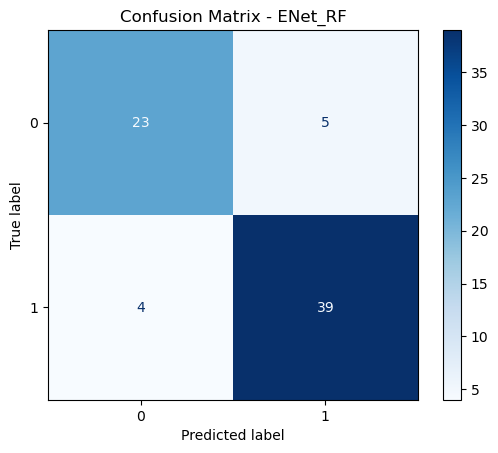

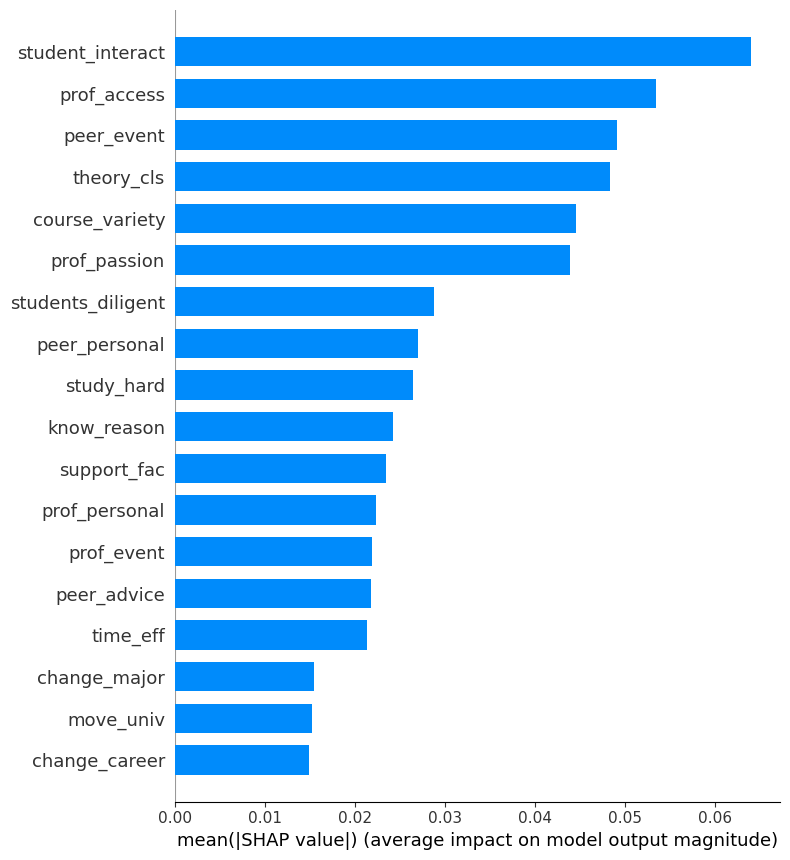

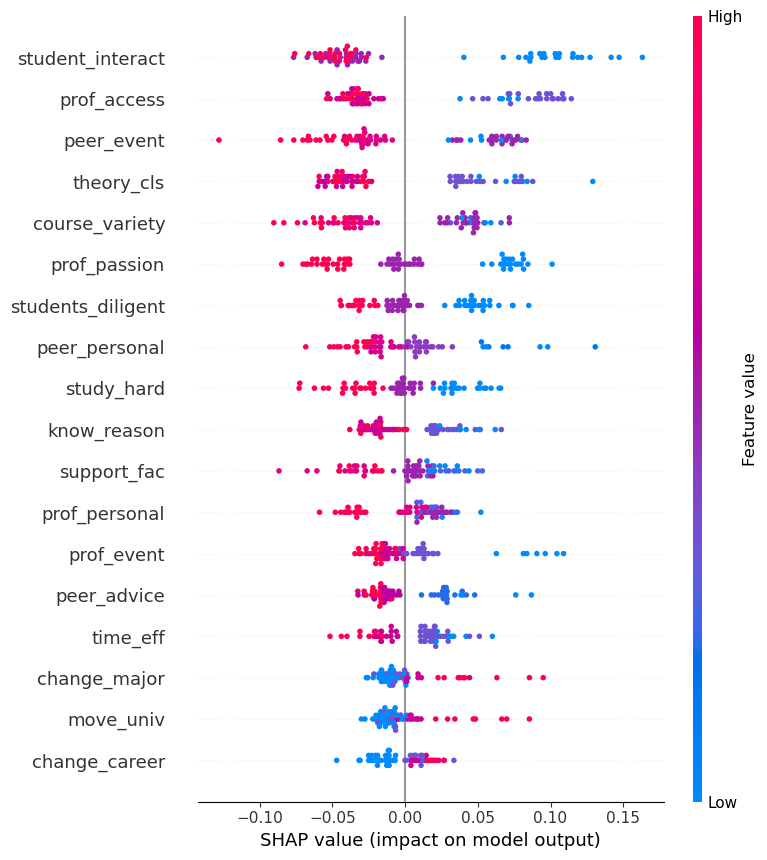


üîπ ENet_RF SHAP Importance (mean / mean_abs)


feature  shap_mean  shap_mean_abs
0    student_interact   0.002831       0.064060
14        prof_access   0.012301       0.053456
2          peer_event   0.001131       0.049097
4          theory_cls  -0.001326       0.048410
13     course_variety  -0.001896       0.044578
12       prof_passion   0.003152       0.043882
17  students_diligent   0.009085       0.028799
9       peer_personal  -0.000185       0.027016
5          study_hard   0.000380       0.026492
1         know_reason   0.000732       0.024267
3         support_fac  -0.001249       0.023433
6       prof_personal   0.002184       0.022342
8          prof_event   0.001320       0.021883
15        peer_advice  -0.000671       0.021774
11           time_eff   0.007037       0.021337
16       change_major  -0.000607       0.015472
10          move_univ  -0.002460       0.015287
7       change_career  -0.003521       0.014857

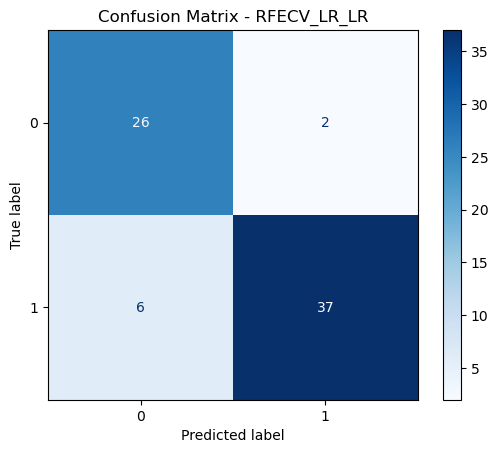

c:\Users\SAMSUNG\anaconda3\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


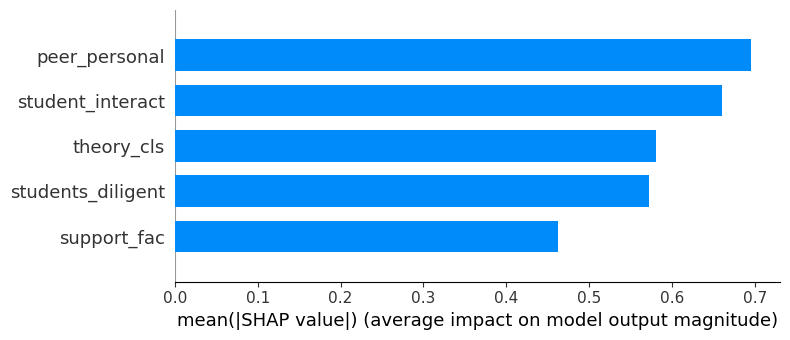

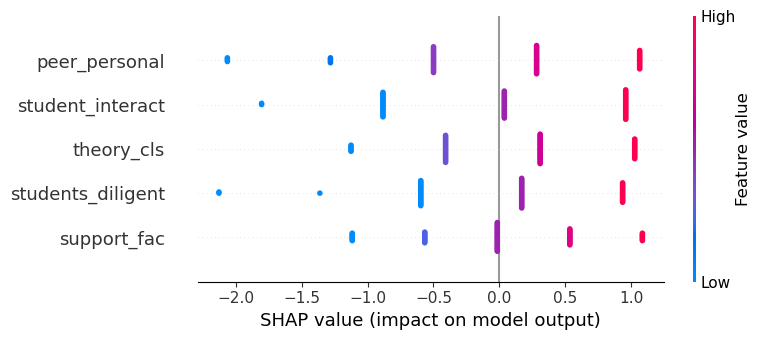


üîπ RFECV_LR_LR SHAP Importance (mean / mean_abs)


feature  shap_mean  shap_mean_abs
2      peer_personal  -0.026840       0.695648
3   student_interact   0.036786       0.660590
1         theory_cls   0.126451       0.581191
4  students_diligent   0.028219       0.572772
0        support_fac   0.022219       0.462104

         Model  CV_F1  CV_Precision  CV_Recall  CV_AUC  Test_F1  Test_ACC  \
0      ENet_RF  0.860         0.843      0.877   0.898    0.897     0.873   
1  RFECV_LR_LR  0.866         0.840      0.896   0.902    0.902     0.887   

   Test_Precision  Test_Recall  Test_AUC    Confusion_Matrix  
0           0.886        0.907     0.910  [[23, 5], [4, 39]]  
1           0.949        0.860     0.949  [[26, 2], [6, 37]]  


In [34]:
# ======================================
# üîπ Í¥ÄÏã¨ Î™®Îç∏Îßå CV + Test ÏÑ±Îä• + Confusion Matrix + SHAP
# ======================================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (f1_score, accuracy_score, precision_score,
                             recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# -------------------------
# Í¥ÄÏã¨ Î™®Îç∏ Ï†ïÏùò
# -------------------------
subset_models = {
    "ENet_RF": RandomForestClassifier(random_state=42),          # ElasticNet ÌõÑÎ≥¥ Î≥ÄÏàò ‚Üí RF
    "RFECV_LR_LR": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)  # RFECV(LR) ÌõÑÎ≥¥ Î≥ÄÏàò ‚Üí LR
}

subset_X_train = {
    "ENet_RF": X_train[list(enet_common)],
    "RFECV_LR_LR": X_train[list(rfecv_lr_common)]
}

subset_X_test = {
    "ENet_RF": X_test[list(enet_common)],
    "RFECV_LR_LR": X_test[list(rfecv_lr_common)]
}

# -------------------------
# Í≤∞Í≥º Ï†ÄÏû•
# -------------------------
results_list = []
shap_results = {}

for name, model in subset_models.items():
    X_tr = subset_X_train[name]
    X_te = subset_X_test[name]

    # Logistic RegressionÏùÄ Pipeline Ï†ÅÏö©
    use_pipe = True if "LR" in name else False
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)]) if use_pipe else model

    # -------------------------
    # CV ÏÑ±Îä•
    # -------------------------
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='f1').mean()
    cv_precision = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='precision').mean()
    cv_recall = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='recall').mean()
    cv_auc = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='roc_auc').mean()

    # -------------------------
    # Hold-out(Test) ÏÑ±Îä•
    # -------------------------
    pipe.fit(X_tr, y_train)
    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe, "predict_proba") else None

    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)

    # -------------------------
    # Confusion Matrix ÏãúÍ∞ÅÌôî
    # -------------------------
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=pipe.named_steps['clf'].classes_ if use_pipe else model.classes_)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # -------------------------
    # SHAP Í≥ÑÏÇ∞
    # -------------------------
    if isinstance(model, RandomForestClassifier):
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer(X_te)
        shap_array = shap_vals.values
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(pipe.named_steps['clf'],
                                         pipe.named_steps['scaler'].transform(X_tr),
                                         feature_perturbation="interventional")
        shap_vals = explainer(pipe.named_steps['scaler'].transform(X_te))
        shap_array = shap_vals.values
    else:
        raise ValueError(f"Unsupported model type: {type(model)}")

    # -------------------------
    # SHAP array Ï∞®Ïõê Ï≤òÎ¶¨
    # -------------------------
    if shap_array.ndim == 3:
        shap_array = shap_array[:, :, 0]  # (samples, features, 1) -> (samples, features)
    elif shap_array.ndim != 2:
        raise ValueError(f"Unexpected SHAP array shape: {shap_array.shape}")

    # -------------------------
    # SHAP DataFrame
    # -------------------------
    shap_df = pd.DataFrame({
        "feature": X_te.columns,
        "shap_mean": shap_array.mean(axis=0),
        "shap_mean_abs": np.abs(shap_array).mean(axis=0)
    }).sort_values(by="shap_mean_abs", ascending=False)

    shap_results[name] = shap_df

    # SHAP Summary Plot
    plt.figure()
    shap.summary_plot(shap_array, X_te, plot_type="bar", show=True)
    plt.figure()
    shap.summary_plot(shap_array, X_te, plot_type="dot", show=True)
    print(f"\nüîπ {name} SHAP Importance (mean / mean_abs)")
    display(shap_df)

    # -------------------------
    # Í≤∞Í≥º Ï†ÄÏû•
    # -------------------------
    results_list.append({
        "Model": name,
        "CV_F1": cv_f1, "CV_Precision": cv_precision, "CV_Recall": cv_recall, "CV_AUC": cv_auc,
        "Test_F1": test_f1, "Test_ACC": test_acc, "Test_Precision": test_precision,
        "Test_Recall": test_recall, "Test_AUC": test_auc, "Confusion_Matrix": cm.tolist()
    })

# -------------------------
# ÏµúÏ¢Ö Í≤∞Í≥º DataFrame
# -------------------------
comparison_df = pd.DataFrame(results_list)
print(comparison_df.round(3))


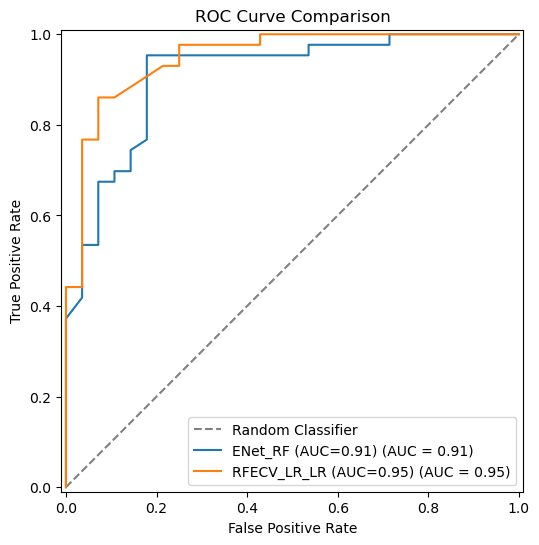

In [38]:
plt.figure(figsize=(8,6))
ax = plt.gca()  # ÌòÑÏû¨ axes Í∞ÄÏ†∏Ïò§Í∏∞

# ROC Í∏∞Ï§ÄÏÑ†
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")

# Î™®Îç∏ ROC
for name, model in subset_models.items():
    X_tr = subset_X_train[name]
    X_te = subset_X_test[name]

    use_pipe = True if "LR" in name else False
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)]) if use_pipe else model
    pipe.fit(X_tr, y_train)

    y_proba = pipe.predict_proba(X_te)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_proba, name=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})", ax=ax)

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
